In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

x = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2, -0.3, -0.4, -0.5]

# Approximate Entropy

- Set embedding m which is length of each block. Divide the series into blocks and compare their similarity.

- Set r which is the noise filter.

Starting with first block $x(i) = x(1) = [u(1), u(2)] = [-0.5, -0.4]$, we compare the rest
of blocks of length $m = 2$ in the sequence with $x(1)$ to see if the difference between all the positions of the vectors
is $\leq r$. If so, we consider that block 'possible'.

First $x(1)$ will compare with itself and would be an
obvious coincidence ("self-counting", which upon analysis actually implies a statistical bias that would need to be
resolved.)

Then, $x(j) = x(2) = [u(2), u(3)] = [-0.4, -0.3]$ is compared with $x(1)$ component to component. Their distance between
first components $|d[u(1) - u(2)| = |-0.1| \leq 0.15$ so we check second component. Both satisfies $\leq r$ so those two
blocks of length $m$ are possible.

We then check the following component $m + 1$ after those two blocks to see if that component continues meeting the
condition, or if there is a pattern. $|d[u(3) - u(4)]| = |d[-0.3, -0.2]| = |-0.1| \leq 0.15$. This is a match and shows
that the pattern continues the same after two blocks.

We continue to compare all the remaining blocks up to $j = N - m + 1$ with $x(1)$. Afterwards, we choose $x(2)$ as template
and continue in the same way.

Note, when we use block $x(9)$ as template, it's easy to prove that block $x(8)$ is a match. For block $x(12)$, even though
 $|d[u(9) - u(12)]| = |d[0.3, 0.4]| \leq 0.15$ and $|d[u(10) - u(13)]| = |d[0.4, 0.3]| \leq 0.15$. However, the next component
 $|d[u(11) - u(14)]| = |d[0.5, 0.2]| \geq 0.15$ so $x(9)$ and $x(12)$ is not a match. This is understandable as $x(9)$
 follows an up-up pattern while $x(12)$ follows a down-down, shown in picture below.

![](./images/pic1.jpg)

In [2]:
m = 2
r = 0.15

In [3]:
def _embed(x, order=3, delay=1):
    N = len(x)
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

_embed(x, order=2)

array([[-0.5, -0.4],
       [-0.4, -0.3],
       [-0.3, -0.2],
       [-0.2, -0.1],
       [-0.1,  0. ],
       [ 0. ,  0.1],
       [ 0.1,  0.2],
       [ 0.2,  0.3],
       [ 0.3,  0.4],
       [ 0.4,  0.5],
       [ 0.5,  0.4],
       [ 0.4,  0.3],
       [ 0.3,  0.2],
       [ 0.2,  0.1],
       [ 0.1,  0. ],
       [ 0. , -0.1],
       [-0.1, -0.2],
       [-0.2, -0.3],
       [-0.3, -0.4],
       [-0.4, -0.5]])

Given that x = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]. We would get the following probabilities for
each block.

In [4]:
from sklearn.neighbors import KDTree

def match_block(x, order, metric='chebyshev'):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics

    phi = np.zeros(2)
    # r = 0.2 * np.std(x, ddof=0)
    r = 0.15

    # compute phi(order, r)
    emb_data1 = _embed(x, order, 1)

    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    return emb_data1.shape[0], emb_data2.shape[0], count1, count2

x = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
match_block(x, 2)

(10,
 9,
 array([2., 3., 3., 3., 3., 3., 3., 3., 3., 2.]),
 array([2., 3., 3., 3., 3., 3., 3., 3., 2.]))

![](./images/pic2.jpg)

Conditional probability $C_i$ is the ratio between the matches over possibles (those cases where only vectors of length
$m$ fulfills close condition, but not the following component $m + 1$).

With the table of probabilities, we can calculate the average of the logarithm of those probabilities (matches/possibles)
and define ApEn as the negative value of that quantity.

In the above example, the ApEn is close to 0, implying the series is very predictable.

In [5]:
shape_1, shape_2, count1, count2 = match_block(x, 2)
phi = np.zeros(2)
phi[0] = np.mean(np.log(count1 / shape_1))
phi[1] = np.mean(np.log(count2 / shape_2))

print(phi[0], phi[1])

-1.285065825947569 -1.1887156460254797


In [6]:
print("App Ent: ", np.subtract(phi[0], phi[1]))


App Ent:  -0.09635017992208916


If we extrapolate the previous series [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1, 0,
-0.1, -0.2, -0.3, -0.4] 7 times, and shuffle a copy of it. Even though the 2 series have the same moment statistics, the
ApEn is $\approx 0$ and $0.526$ respectively. ApEn gives lower values to the organized series.


In [7]:
import random
x = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.4, 0.3, 0.2, 0.1, 0, -0.1, -0.2, -0.3, -0.4]
extrapolated_series = x * 7
extrapolated_series_randomized = extrapolated_series[:]
random.shuffle(extrapolated_series_randomized)

<AxesSubplot:>

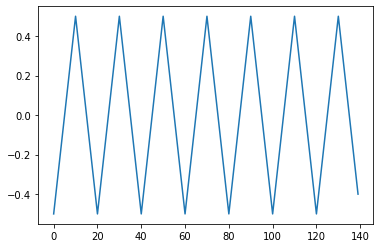

In [8]:
pd.Series(extrapolated_series).plot()

<AxesSubplot:>

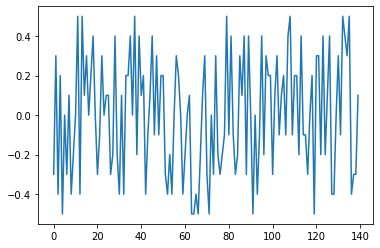

In [9]:
pd.Series(extrapolated_series_randomized).plot()

In [10]:
from entropy import *

print(app_entropy(extrapolated_series))
print(app_entropy(extrapolated_series_randomized))

-0.0004698272115795099
0.5660334181081073


Properties of ApEn:
1. ApEn statistics independent of any model, so it is suitable for analysis of time series without taking into account
anything else but the data
2. ApEn is stable to large and infrequent outliers (low probability events).
3. ApEn is non-negative. Value is 0 for perfectly regular series.
4. ApEn is $ln2$ for totally random binary series, and $lnk$ for alphabets of $k$ symbols.
5. ApEn not affected by uniform translation or scaling applied to all terms. ApEn is not invariant under coordinate
transformations, hence scale must be fixed.
6. ApEn is not fully consistent.
7. $m$ should be low (m = 2 or 3)
8. $r$ is generally $0.2 * std(series)$
9. Number of data required is generally $10^m$ to $30^m$, but since $m$ is small, we only need about $N = 100$
10. Systems with substantial noise can undermine ApEn
11. ApEn makes use of data vectors $x_i$ instead of probabilities associated with occurrence of each result $p_i$
12. ApEn require equally spaced measurements over time
13. ApEn is biased statistics
    - Due to self-match when calculating $C^{m}_{i}(r)$. The higher N, the lower bias.

Bias of ApEn:
- Suggest more regularity than there is in reality
- By allowing each vector to count itself, all functions $C^{m}_{i}(r)$ remains positive to avoid situations where we
have to calculate $log(0)$. $C^{m}_{i}(r)$ is basically conditional probabilities calculated as sum of (matches)/(total
of possible vectors) among the target vectors, so self-counting allows always at least 1 match and 1 possible vector. If
we have $B_i$ as possible vectors and $A_i$ as all the matches, the ApEn calculates $(A_i + 1) / (B_i + 1) which is always
greater than $(A_i) / (B_i)$ without bias. This bias is more obvious for samples with small number of points N.

# Sample Entropy

To counter 2 limitations of AppEn: no relative consistency and value dependent on length of data series.

SampEn does not have self-counting. $SampEn(m, r, N)$ is negative value of logarithm of the conditional probability that
two similar sequences of $m$ points remain similar at the next point $m + 1$, counting each vector over all other vectors
**except on itself**.

It implies that SampEn maintains the relative consistency and is also mostly independent of the series length.

Formula:
1. Define total number of possible vectors by calculating for each template vector:
<img src="images/pic3.jpg" width="600">
and adding all template vectors:
<img src="images/pic4.jpg" width="600">
In the same way, we define total number of matches by calculating for each model vector:
<img src="images/pic5.jpg" width="600">

Therefore, $B^m(r)$ is the probability that two sequences are similar for $m$ points (possibles), while $A^m(r)$ is the
probability that two sequences are similar for $m + 1$ points (matches). Number of matches is always $\leq$ number of
possible vectors, the ratio $A^m(r) / B^m(r)$ is a conditional probability less than unity.

Statistic $SampEn(m, r, N) = -log[A^m(r)/B^m(r)]$ is an estimate for $SampEn(m, r)$.

For ApEn:
<img src="images/pic6.jpg" width="600">

The error committed in this approximation is $< 0.05$ for $N - m + 1 > 90$ and $< 0.02$ for $N - m + 1 > 283$

Comparing the two algorithms:
<img src="images/pic7.jpg" width="600">

1. SampEn no self-counting $(j != i)$ while ApEn does
2. Sum of all template vectors is inside the logarithm in SampEn and outside in ApEn. It implies SampEn considers the
complete series and if a template finds a match, then SampEn is already defined, while ApEn needs a match for each template.
Jensen's inequality says $log(\sum) > \sum log$ so the term is greater in SampEn than in ApEn.
3. ApEn includes a factor $\frac{1}{N-m}$ which makes the statistic dependent on size of the series, whereas SampEn does
not include it.

In [11]:
def _embed(x, order=3, delay=1):
    N = len(x)
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

x = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
_embed(x, order=2)

array([[-0.5, -0.4],
       [-0.4, -0.3],
       [-0.3, -0.2],
       [-0.2, -0.1],
       [-0.1,  0. ],
       [ 0. ,  0.1],
       [ 0.1,  0.2],
       [ 0.2,  0.3],
       [ 0.3,  0.4],
       [ 0.4,  0.5]])

In [12]:
def match_block(x, order, metric='chebyshev'):
    """Utility function for `app_entropy`` and `sample_entropy`.
    """
    _all_metrics = KDTree.valid_metrics

    phi = np.zeros(2)
    r = 0.2 * np.std(x, ddof=0)

    # compute phi(order, r)
    _emb_data1 = _embed(x, order, 1)
    emb_data1 = _emb_data1[:-1]

    count1 = KDTree(emb_data1, metric=metric).query_radius(emb_data1, r,
                                                           count_only=True
                                                           ).astype(np.float64)
    emb_data2 = _embed(x, order + 1, 1)
    count2 = KDTree(emb_data2, metric=metric).query_radius(emb_data2, r,
                                                           count_only=True
                                                           ).astype(np.float64)

    return emb_data1.shape[0], emb_data2.shape[0], count1, count2

shape_1, shape_2, count1, count2 = match_block(x, 2)
phi = np.zeros(2)
phi[0] = np.mean((count1 - 1) / (shape_1 - 1))
phi[1] = np.mean((count2 - 1) / (shape_2 - 1))

print(phi[0], phi[1])
samp_en = -np.log(np.divide(phi[1], phi[0]))

print(samp_en)

0.0 0.0
nan


<ipython-input-12-cc8437b20a0f>:29: RuntimeWarning: invalid value encountered in true_divide
  samp_en = -np.log(np.divide(phi[1], phi[0]))


From the above example, we can see that even though SampEnt is less dependent on dataset length and preserve relative
consistency over a broader range of $m, r, N$ values, $SampEn(m, r, N)$ is undefined if no template or forward match
occurs in the case of small $N$ and $r$.

<AxesSubplot:>

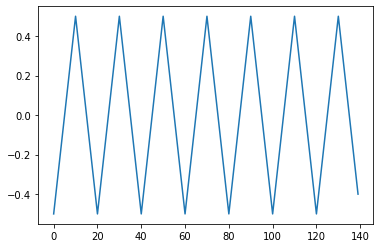

In [13]:
pd.Series(extrapolated_series).plot()

<AxesSubplot:>

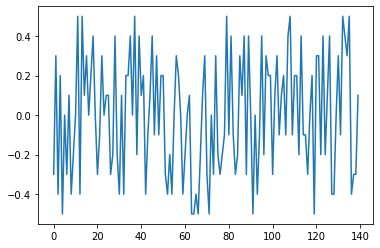

In [14]:
pd.Series(extrapolated_series_randomized).plot()

Compare SampEn with ApEn:

In [21]:
print("SampEn for series 1: ", sample_entropy(extrapolated_series))
print("SampEn for series 2: ", sample_entropy(extrapolated_series_randomized))

SampEn for series 1:  -0.0
SampEn for series 2:  2.3581549441488563


- SampEn has higher value than ApEn
- Both successfully detects randomness from perfect regularity
